# 10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

글자 단위(Character-level) → 단어 단위(Word-level) 번역을 해보자

---
## Step 0. 시작 전 주요 라이브러리 및 데이터 호출

In [1]:
import os
import re

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import unicodedata

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Dropout
from tensorflow.keras.models import Model


In [2]:
# Google Drive - Colab  연동을 위한 라이브러리 Import
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Exploration/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = data_dir+'/seq2seq/fra.txt'
sentences = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(sentences))
sentences.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
125962,Spring will be here before long.,Le printemps est pour bientôt.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
74381,That's a very old saying.,C'est un très vieil adage.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
118898,No criminal charges were filed.,Aucune accusation criminelle n'a été enregistrée.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
128876,He convinced me of his innocence.,Il m'a convaincu de son innocence.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9598,Am I qualified?,Est-ce que je réponds aux critères ?,CC-BY 2.0 (France) Attribution: tatoeba.org #8...


In [4]:
del sentences['cc']
sentences.head()

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


---
## Step 1. 정제, 정규화, 전처리 (+토큰화)

[참고] 글자 단위가 아닌 단어 번역을 위한 추가적인 전처리가 필요하다.
1. 구두점(Punctuation)을 단어와 분리
2. 소문자로 치환
3. 띄어쓰기 단위로 토큰화 수행

전처리에 앞서, 사용 할 샘플의 양은 전체 데이터에서 33,000개이다.

In [5]:
# 사용 할 senteces
num_samples = 33000

전처리 함수 구현

In [6]:
def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
  # 악센트 제거 함수 호출
  sent = to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백 추가.
  # ex) "I am a student." => "I am a student ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [7]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


훈련 시 사용할 레이블에 해당되는 출력 시퀀스를 따로 분리하여 저장한다.

입력 시퀀스에는 시작을 의미하는 토큰인 <sos>를 추가하고,  
출력 시퀀스에는 종료를 의미하는 토큰인 <eos>를 추가한다.

In [8]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open(file_path, "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

In [9]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


케라스 토크나이저를 통해 단어 집합을 생성, 정수 인코딩을 진행 후 이어서 패딩을 진행합니다.

In [10]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [11]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


단어 집합 크기에 대한 정의

In [12]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4672, 프랑스어 단어 집합의 크기 : 8137


In [13]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

train/test를 분리하기 전 데이터를 무작위로 섞어준다.

In [14]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [31336 21483  9349 ...   619 13729 28767]


In [15]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

사용 할 samples 각각 30000 / 3000 개의 train / validation으로 분리하자

In [16]:
# Validation dat의 수
n_of_val = 3000

In [17]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [18]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 16)
훈련 target 레이블의 크기 : (30000, 16)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 16)
테스트 target 레이블의 크기 : (3000, 16)


---
## Step 2. 임베딩 층(Embedding layer) 사용하기

> 주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,  
> 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 합니다!

In [19]:
embedding_dim = 64
hidden_units = 64

In [20]:
# 인코더
encoder_inputs = Input(shape=(None,))

enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [21]:
# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)
# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 
# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

---
## Step 3. 모델 구현

In [22]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     299008      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     520768      ['input_2[0][0]']                
                                                                                              

---
## Step 4. 모델 평가

In [24]:
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test],
                     decoder_target_test), batch_size=128, epochs=50, callbacks=[stop])

Epoch 1/50
235/235 [==============================] - 137s 537ms/step - loss: 3.4121 - acc: 0.6144 - val_loss: 2.0678 - val_acc: 0.6182
Epoch 2/50
235/235 [==============================] - 120s 511ms/step - loss: 1.9000 - acc: 0.6569 - val_loss: 1.7746 - val_acc: 0.7212
Epoch 3/50
235/235 [==============================] - 122s 520ms/step - loss: 1.6964 - acc: 0.7380 - val_loss: 1.6225 - val_acc: 0.7473
Epoch 4/50
235/235 [==============================] - 120s 510ms/step - loss: 1.5499 - acc: 0.7550 - val_loss: 1.4861 - val_acc: 0.7627
Epoch 5/50
235/235 [==============================] - 122s 520ms/step - loss: 1.4341 - acc: 0.7664 - val_loss: 1.4017 - val_acc: 0.7727
Epoch 6/50
235/235 [==============================] - 121s 514ms/step - loss: 1.3529 - acc: 0.7757 - val_loss: 1.3307 - val_acc: 0.7833
Epoch 7/50
235/235 [==============================] - 123s 522ms/step - loss: 1.2778 - acc: 0.7903 - val_loss: 1.2677 - val_acc: 0.7965
Epoch 8/50
235/235 [============================

(얼리스탑 왜씀..)

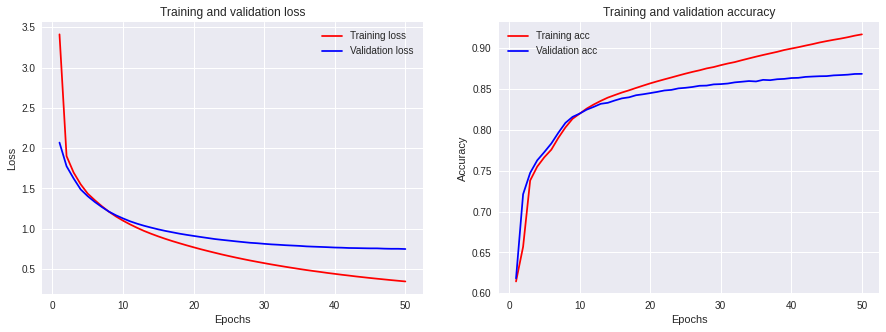

In [25]:
plt.style.use('seaborn')
graph = history.history

acc = graph['acc']
val_acc = graph['val_acc']
loss = graph['loss']
val_loss = graph['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Loss / Acc 곡선을 보니 학습 자체에는 큰 문제가 없어보인다.

---
## Step 5. 번역기 확인

테스트를 위한 모델 설계

In [26]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

번역기의 테스트 동작을 위한 decode_sequence 함수 구현  
정수로 변환된 단어들을 텍스트 sequence로 변환하기 위함이다.

In [27]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [28]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

샘플에서 임의의 인덱스에 해당하는 샘플들의 결과를 출력

In [33]:
for seq_index in [356, 826, 1024, 1214, 1717]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 23ms/step
입력문장 : good luck . 
정답문장 : bonne chance . 
번역문장 : bonne chance . 
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : it s for free . 
정답문장 : c est gratuit . 
번역문장 : c est gratuit . 
--------------------------------------------------
1/1 [==============================] - 0s 25ms/step
입력문장 : no one is there . 
정답문장 : il n y a personne . 
번역문장 : personne ne s est la . 
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : tom wore goggles . 
정답문장 : tom portait des lunettes de securite . 
번역문장 : tom portait des lunettes de protection . 
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : hang on ! 
정답문장 : attendez un peu ! 
번역문장 : tiens bon . 
--------------------------------------------------


---
- 입력문장 : good luck .  
- 정답문장 : bonne chance . -> 행운을 빌어요.  
- 번역문장 : bonne chance . -> 행운을 빌어요.  
---
- 입력문장 : it s for free .  
- 정답문장 : c est gratuit . -> 무료입니다.  
- 번역문장 : c est gratuit . -> 무료입니다.  
---
- 입력문장 : no one is there .  
- 정답문장 : il n y a personne .    -> 아무도 없어요.  
- 번역문장 : personne ne s est la . -> 아무도 거기 있지 않다.
---
- 입력문장 : tom wore goggles .  
- 정답문장 : tom portait des lunettes de securite .   -> 탐은 보안경을 쓰고 있었습니다.  
- 번역문장 : tom portait des lunettes de protection . -> 탐은 보호 안경을 쓰고 있었습니다.
---
- 입력문장 : hang on !  
- 정답문장 : attendez un peu ! -> 잠깐 기다려요!  
- 번역문장 : tiens bon .       -> 조금만 참아.  
---

출력을 몇 회 반복 후, 의미 있는 문장들을 고른 것이지만 의외로 높은 정답률을 보였다.

---
## DISCUSSION

- 엄밀히 따지면 영어와 불어에는 알파벳을 쓴다는 것은 비슷하지만, 문자나 축약에 대한 차이가 있어서 일괄적인 전처리를 통해 매끄러운 번역을 얻는 다는 것은 힘든 일인 것 같았다.
- 부끄럽지만 이번 노드는 난이도가 너무 어려워서 코드 스크랩핑이 전부였다. 그래도 그 과정에서 인코딩과 디코딩에 대한 이해나 교사강요에 대해 어느 정도 감을 잡고 다시 한번 학습할 수 있는 기회였다.
- 앞으로 Exploration node가 얼마 남지 않았는데, 남은 과정 착실히 수행하고 전반기 끝나고 잠깐 쉬는 기간에 총정리 겸 복습이 절실함을 느꼈다(그저 반성..). NLP/CV 구분 없이 잘할 수 있게 좀더 열의를 가지고 공부해야겠다.